С сайта https://www.kaggle.com/ необходимо загрузить датасет на ваш выбор. Желательно, чтобы датасеты внутри группы были разные.
1.	Сформулировать задачу, которую решаете
2.	Сделать анализ данных (пропуски, выбросы, как с этим бороться и прочее)
3.	Выбрать метрики для решения вашей задачи
4.	Обучить 3 классических модели и 1-2 нейронные сети
5.	Подробно объяснить результаты
Для решения задачи вам в помощь ноутбуки с практик + документации для библиотек питона


https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset/data

Задача определния оценки за экзамен (регрессия)


метрики, предназначенные именно для оценки точности предсказания чисел:

MAE (Средняя абсолютная ошибка) — показывает, на сколько баллов в среднем ошибается модель.

RMSE (Корень из среднеквадратичной ошибки) — штрафует за крупные отклонения.

$R^2$ (Коэффициент детерминации) — показывает долю объясненной дисперсии (насколько модель лучше, чем простое предсказание среднего значения).

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB
None

--- NA Check ---
student_id          0
age                 0
gender              0
course           

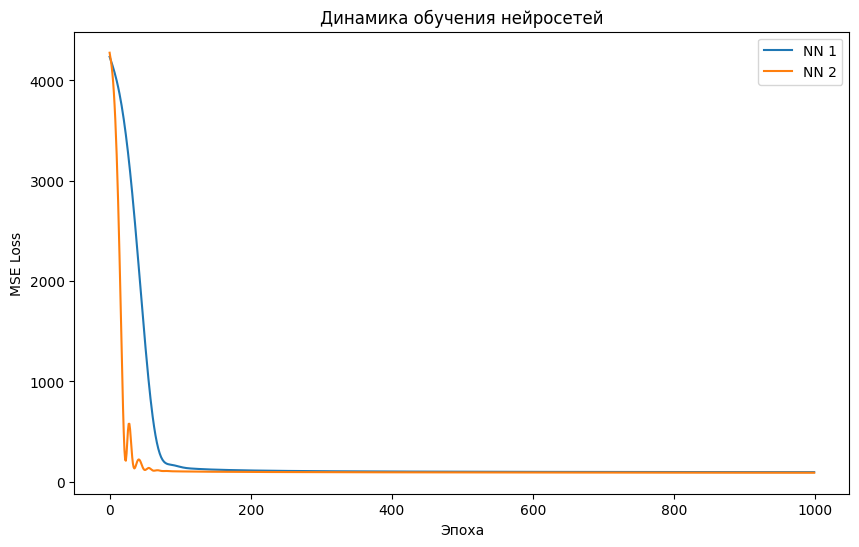


##################################################
 ИТОГОВЫЙ ОТЧЕТ 
##################################################
       Model    MAE    RMSE     R2
   LinearReg 7.8786  9.7929 0.7343
         SVR 8.1664 10.1004 0.7173
 NeuralNet_2 8.1430 10.1298 0.7157
 NeuralNet_1 8.2197 10.2312 0.7100
RandomForest 8.5532 10.5811 0.6898

--- ВЫВОДЫ ---
1. Лучшая модель: LinearReg
   - Коэффициент детерминации (R2): 0.7343
   - Средняя абсолютная ошибка (MAE): 7.88 баллов
Качество прогноза: Приемлемое.
Линейная регрессия победила. Это означает, что зависимость между учебными часами/факторами и оценкой — линейная.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

df = pd.read_csv("Exam_Score_Prediction.csv")

print("--- Data Info ---")
print(df.info())
print("\n--- NA Check ---")
print(df.isna().sum())

# Очистка и предобработка
df = df.dropna()
df = pd.get_dummies(df, drop_first=True)

X = df.drop("exam_score", axis=1)
y = df["exam_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

final_results = []

# КЛАССИЧЕСКИЕ МОДЕЛИ
models = {
    "LinearReg": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "SVR": SVR()
}

print("\n" + "="*30)
print("Классические модели")
print("="*30)

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"{name}: R2 = {r2:.4f}")

    # Сохраняем результат
    final_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

# НЕЙРОННЫЕ СЕТИ
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

class Net(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

nets = [
    Net([nn.Linear(X_train.shape[1], 32), nn.ReLU(), nn.Linear(32, 1)]),
    Net([nn.Linear(X_train.shape[1], 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1)])
]

all_losses = []

print("\n" + "="*30)
print("Обучение нейросети")
print("="*30)

for i, net in enumerate(nets):
    opt = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    current_losses = []

    epochs = 1000
    for epoch in range(epochs):
        opt.zero_grad()
        output = net(X_train_t)
        loss = loss_fn(output, y_train_t)
        loss.backward()
        opt.step()
        current_losses.append(loss.item())

        if (epoch+1) % 200 == 0:
            print(f"NN {i+1} | Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

    all_losses.append(current_losses)

    # Оценка
    with torch.no_grad():
        preds = net(X_test_t).numpy().flatten()

        mae = mean_absolute_error(y_test, preds)
        rmse = root_mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        name = f"NeuralNet_{i+1}"
        print(f"Finished {name}: R2 = {r2:.4f}")

        final_results.append({
            "Model": name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# График обучения
plt.figure(figsize=(10, 6))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f"NN {i+1}")
plt.xlabel("Эпоха")
plt.ylabel("MSE Loss")
plt.title("Динамика обучения нейросетей")
plt.legend()
plt.show()

# ИТОГОВЫЕ ВЫВОДЫ
results_df = pd.DataFrame(final_results).sort_values(by="R2", ascending=False)

print("\n" + "#"*50)
print(" ИТОГОВЫЙ ОТЧЕТ ")
print("#"*50)
print(results_df.round(4).to_string(index=False))

best_model = results_df.iloc[0]
print("\n--- ВЫВОДЫ ---")
print(f"1. Лучшая модель: {best_model['Model']}")
print(f"   - Коэффициент детерминации (R2): {best_model['R2']:.4f}")
print(f"   - Средняя абсолютная ошибка (MAE): {best_model['MAE']:.2f} баллов")

# Оценка качества
if best_model['R2'] > 0.8:
    quality = "Высокое"
elif best_model['R2'] > 0.6:
    quality = "Приемлемое"
else:
    quality = "Низкое"

print(f"Качество прогноза: {quality}.")

# Победитель
model_name = best_model['Model']
if "Linear" in model_name:
    print("Линейная регрессия победила. Это означает, что зависимость между учебными часами/факторами и оценкой — линейная.")
elif "Forest" in model_name:
    print("Random Forest победил. Данные содержат сложные нелинейные зависимости и выбросы, с которыми деревья справились лучше.")
elif "Neural" in model_name:
    print("Нейросеть победила. После настройки гиперпараметров она смогла уловить скрытые паттерны лучше классических методов.")


Результаты показывают интересную картину: самая простая модель оказалась самой эффективной.

Модель	Вердикт

LinearReg	Победитель. Лучший баланс точности и простоты.

SVR	Хороший результат, но вычислительно сложнее.

NeuralNet_2	Вторая по силе модель, более сложная архитектура помогла ей обойти первую сеть.

NeuralNet_1	Базовая нейросеть, показала достойный результат.

RandomForest	Худший результат в данном тесте (вероятно, из-за склонности к переобучению на этих данных).

Скорее всего в данных нет сверхсложных скрытых связей, для которых потребовались бы глубокие нейросети.

